# Polynomial and Transformation-Based Regression on Tree Volume

## Overview

This project explores how to model tree volume (\(`Volume`\)) using two explanatory variables—tree girth (\(`Girth`\)) and tree height (\(`Height`\))—from the built-in **R** dataset [`trees`](https://stat.ethz.ch/R-manual/R-devel/library/datasets/html/trees.html). Various transformations (log, square root) and polynomial expansions are used to diagnose and correct issues such as heteroskedasticity and nonlinearity. Ultimately, an optimal model is proposed balancing predictive performance with interpretability.

<br>

## 1. Setup

In [12]:
# Load required libraries
library(plotly)
library(broom)
library(modelsummary)
library(IRdisplay)
library(performance)

In [13]:
# Check out the first few rows of the trees dataset
head(trees)

,Girth,Height,Volume
,<dbl>,<dbl>,<dbl>
1,8.3,70,10.3
2,8.6,65,10.3
3,8.8,63,10.2
4,10.5,72,16.4
5,10.7,81,18.8
6,10.8,83,19.7


> *Output removed intentionally—please run in your environment.*

<br>

## 2. Baseline Linear Model

Our first step is to fit a simple multiple linear regression:  
$$
\text{Volume} = \beta_0 + \beta_1 \,\text{Girth} + \beta_2 \,\text{Height} + \varepsilon
$$


Call:
lm(formula = Volume ~ Girth + Height, data = trees)

Residuals:
    Min      1Q  Median      3Q     Max 
-6.4065 -2.6493 -0.2876  2.2003  8.4847 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept) -57.9877     8.6382  -6.713 2.75e-07 ***
Girth         4.7082     0.2643  17.816  < 2e-16 ***
Height        0.3393     0.1302   2.607   0.0145 *  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 3.882 on 28 degrees of freedom
Multiple R-squared:  0.948,	Adjusted R-squared:  0.9442 
F-statistic:   255 on 2 and 28 DF,  p-value: < 2.2e-16



	Shapiro-Wilk normality test

data:  residuals(lmod_linear)
W = 0.97431, p-value = 0.644


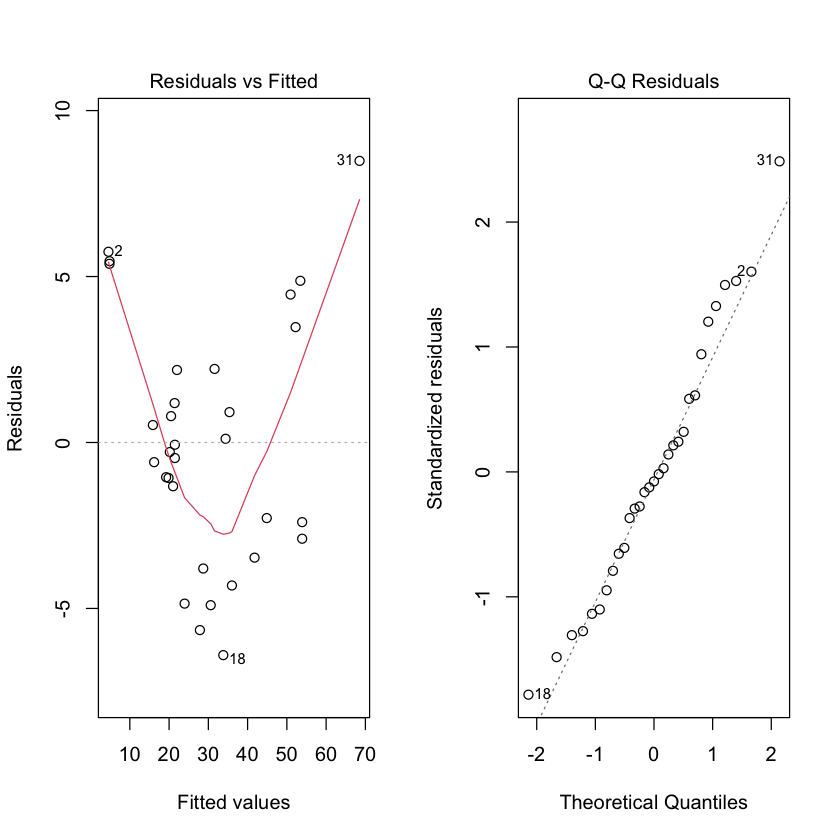

In [14]:
# Fit linear model
lmod_linear <- lm(Volume ~ Girth + Height, data = trees)

# View model summary (omitted output here)
summary(lmod_linear)

# Diagnostic plots
par(mfrow = c(1, 2))
plot(lmod_linear, which = 1)  # Residual vs. Fitted
plot(lmod_linear, which = 2)  # QQ plot
par(mfrow = c(1, 1))

# Check normality of residuals
shapiro.test(residuals(lmod_linear))

> *Interpretation:*  
> - The model explains a large portion of variance in `Volume`.  
> - Residual plots show slight heteroskedasticity.  
> - The Shapiro-Wilk test fails to reject normality of residuals, but the QQ plot suggests minor deviations at the tails.

<br>

## 3. Testing for Heteroskedasticity

Below we perform a quick variance test, splitting residuals into two groups based on whether their fitted values are above or below the median:

In [15]:
# Split residuals into two groups
fitted_vals <- fitted(lmod_linear)
resids <- residuals(lmod_linear)
med_fitted <- median(fitted_vals)

resids_below <- resids[fitted_vals <= med_fitted]
resids_above <- resids[fitted_vals > med_fitted]

# F-test for equal variances
var_test_result <- var.test(resids_above, resids_below)
var_test_result


	F test to compare two variances

data:  resids_above and resids_below
F = 1.7794, num df = 14, denom df = 15, p-value = 0.2801
alternative hypothesis: true ratio of variances is not equal to 1
95 percent confidence interval:
 0.6153815 5.2479116
sample estimates:
ratio of variances 
          1.779363 


> *Interpretation:*  
> 
> Our equal variance test based on residuals above and below the median value is not significant, but does show a ratio of variances of 1.77, meaning there is evidence of unequal variance. Since lower fitted values seem to be associated with less variance, it is possible that applying a log or square root transformation to the response could result in more equal variance. I will look at plots using transformations for the response, predictors, and both, to identify which may help.  

<br>

## 4. Trying Transformations

Often, taking the log or square root of `Volume` helps stabilize variance. We also investigate transforming the predictors themselves.

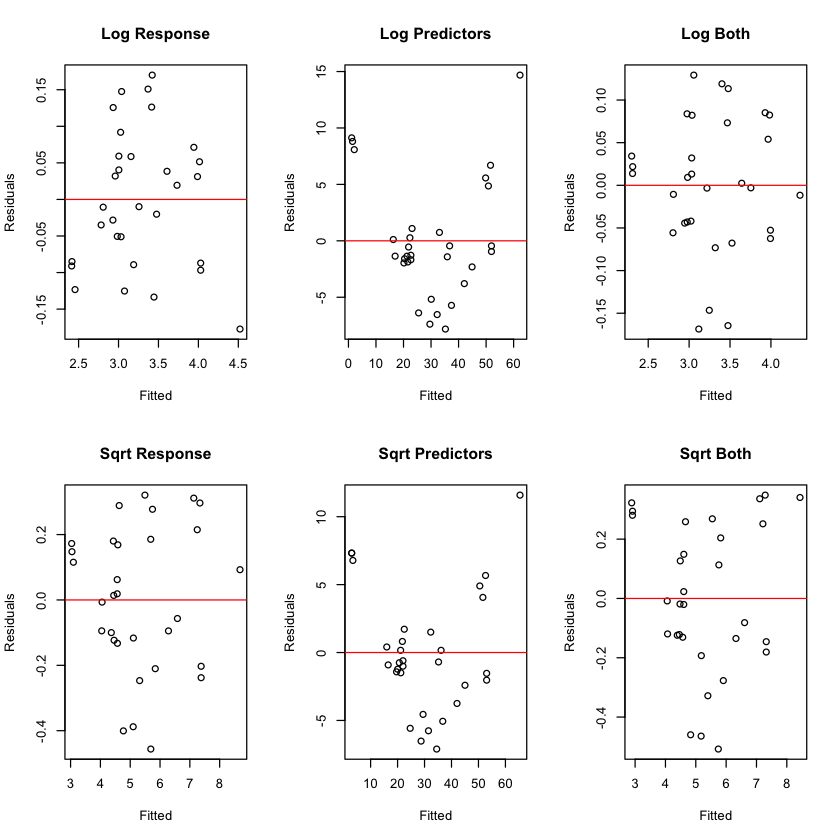

In [16]:
# Create list of models with their transformations

models <- list(
  # Log transformations
  list(name = "Log Response", model = lm(log(Volume) ~ Girth + Height, data = trees)),
  list(name = "Log Predictors", model = lm(Volume ~ log(Girth) + log(Height), data = trees)),
  list(name = "Log Both", model = lm(log(Volume) ~ log(Girth) + log(Height), data = trees)),
  
  # Square root transformations
  list(name = "Sqrt Response", model = lm(sqrt(Volume) ~ Girth + Height, data = trees)),
  list(name = "Sqrt Predictors", model = lm(Volume ~ sqrt(Girth) + sqrt(Height), data = trees)),
  list(name = "Sqrt Both", model = lm(sqrt(Volume) ~ sqrt(Girth) + sqrt(Height), data = trees))
)

# Function to create residual plot
create_residual_plot <- function(model, title) {
  plot(fitted(model), residuals(model),
       main = title, xlab = "Fitted", ylab = "Residuals")
  abline(h = 0, col = "red")
}

par(mfrow = c(2, 3))

for (model_info in models) {
  create_residual_plot(model_info$model, model_info$name)
}

par(mfrow = c(1, 1))

> *Interpretation:*  
> 
> Based on the residual plots, applying either a log or square root transformation to the response variable alone, or to both response and predictors, appears to reduce heteroskedasticity (unequal variance). To determine which transformation is most effective, I will perform var.test() on each model to compare the variance of residuals above and below the median fitted value. 

### 4.1 Variance Test for Each Candidate Model

In [17]:
calc_var_stats <- function(model) {
  fitted <- fitted(model)
  resids <- residuals(model)
  med_fit <- median(fitted)
  
  test_result <- var.test(resids[fitted > med_fit], 
                          resids[fitted <= med_fit])
  
  c(ratio = as.numeric(test_result$statistic), 
    p_value = test_result$p.value)
}

# Compare original linear model plus transformations
lmod_log_response <- lm(log(Volume) ~ Girth + Height, data = trees)
lmod_log_predictors <- lm(Volume ~ log(Girth) + log(Height), data = trees)
lmod_log_both <- lm(log(Volume) ~ log(Girth) + log(Height), data = trees)
lmod_sqrt_response <- lm(sqrt(Volume) ~ Girth + Height, data = trees)
lmod_sqrt_predictors <- lm(Volume ~ sqrt(Girth) + sqrt(Height), data = trees)
lmod_sqrt_both <- lm(sqrt(Volume) ~ sqrt(Girth) + sqrt(Height), data = trees)

models_all <- list(
  "Linear"         = lmod_linear,
  "Log Response"   = lmod_log_response,
  "Log Predictors" = lmod_log_predictors,
  "Log Both"       = lmod_log_both,
  "Sqrt Response"  = lmod_sqrt_response,
  "Sqrt Predictors"= lmod_sqrt_predictors,
  "Sqrt Both"      = lmod_sqrt_both
)

results <- do.call(rbind, lapply(names(models_all), function(name) {
  stats <- calc_var_stats(models_all[[name]])
  data.frame(
    model       = name,
    ratio       = stats["ratio"],
    p_value     = stats["p_value"],
    dist_from_1 = abs(stats["ratio"] - 1)
  )
}))

# Sort by how close the ratio is to 1
results <- results[order(results$dist_from_1), ]
results

,model,ratio,p_value,dist_from_1
,<chr>,<dbl>,<dbl>,<dbl>
ratio6,Sqrt Both,1.362075,0.5592697,0.3620749
ratio1,Log Response,1.498959,0.4458480,0.4989589
ratio2,Log Predictors,1.577598,0.3912364,0.5775978
ratio5,Sqrt Predictors,1.643629,0.3506013,0.6436289
ratio4,Sqrt Response,1.656273,0.3433231,0.6562727
ratio3,Log Both,1.736075,0.3008216,0.7360754
ratio,Linear,1.779363,0.2800772,0.7793626


> *Interpretation:*  
>
> Adding a square root transformation to the response and the predictor seems to cause the greatest reduction in unequal variance according to our median test, though a log transformation is close behind and would be easier to interpret. Additionally, our residual vs fitted plots for Sqrt Both and Log Response have similar randomly scattered residual. I will focus on these two models, and compare them with our linear model without any transformation.


	Shapiro-Wilk normality test

data:  residuals(lmod_log_response)
W = 0.97144, p-value = 0.5594



	Shapiro-Wilk normality test

data:  residuals(lmod_sqrt_both)
W = 0.93613, p-value = 0.06453


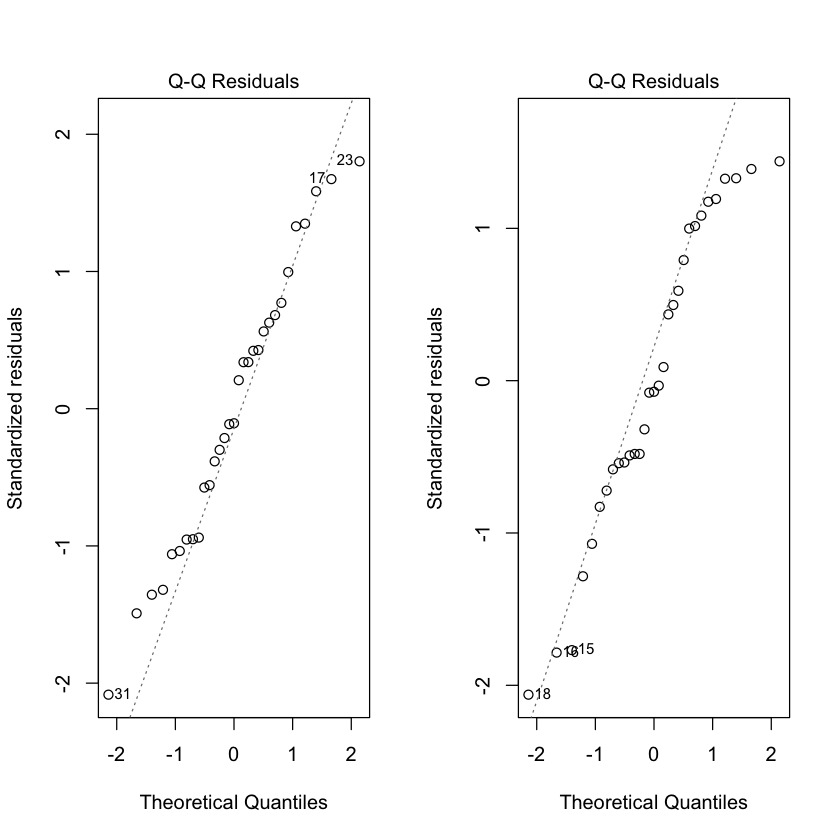

In [18]:
par(mfrow = c(1, 2))
plot(lmod_log_response, which = 2)
plot(lmod_sqrt_both, which = 2)
shapiro.test(residuals(lmod_log_response))
shapiro.test(residuals(lmod_sqrt_both))

> *Interpretation:*  
>
> We have slightly less normal residuals for our log(response) transformation, but fail to reject the null. Our sqrt(both) transformation cause a lot of non-normality, with a much lower p value in our significance test. This drastic drop in normality supports the case for using a log(response) transformation instead. 


## 5. Polynomial Terms & Further Model Refinements
Beyond simple transformations, adding polynomial terms can capture curvature not addressed in purely linear models. I'd like to try applying one more transformation to my models using polynomials, then plotting the polynomial vs non-polynomial graphs for each. 

In [19]:
# Fit linear and polynomial models
lmod_linear <- lm(Volume ~ Girth + Height, data = trees)
lmod_poly <- lm(Volume ~ polym(Girth, Height, degree = 2), data = trees)

# Fit models with log-transformed response
lmod_log <- lm(log(Volume) ~ Girth + Height, data = trees)
lmod_poly_log <- lm(log(Volume) ~ polym(Girth, Height, degree = 2), data = trees)

# Fit models with square root transformed on response and predictors
lmod_sqrt <- lm(sqrt(Volume) ~ sqrt(Girth) + sqrt(Height), data = trees)
lmod_poly_sqrt <- lm(sqrt(Volume) ~ polym(sqrt(Girth), sqrt(Height), degree = 2), data = trees)


# Define ranges for Girth and Height
girth_range <- seq(min(trees$Girth), max(trees$Girth), length.out = 20)
height_range <- seq(min(trees$Height), max(trees$Height), length.out = 20)
prediction_grid <- expand.grid(Girth = girth_range, Height = height_range)

# Predict values for each model
pv_linear <- predict(lmod_linear, newdata = prediction_grid)
pv_poly <- predict(lmod_poly, newdata = prediction_grid)
pv_log <- exp(predict(lmod_log, newdata = prediction_grid))
pv_poly_log <- exp(predict(lmod_poly_log, newdata = prediction_grid))
pv_sqrt <- predict(lmod_sqrt, newdata = prediction_grid)^2
pv_poly_sqrt <- predict(lmod_poly_sqrt, newdata = prediction_grid)^2

### 5.1 Residual Diagnostic Plots


	Shapiro-Wilk normality test

data:  residuals(lmod_poly_log)
W = 0.97286, p-value = 0.6008



	Shapiro-Wilk normality test

data:  residuals(lmod_poly_sqrt)
W = 0.96831, p-value = 0.4738


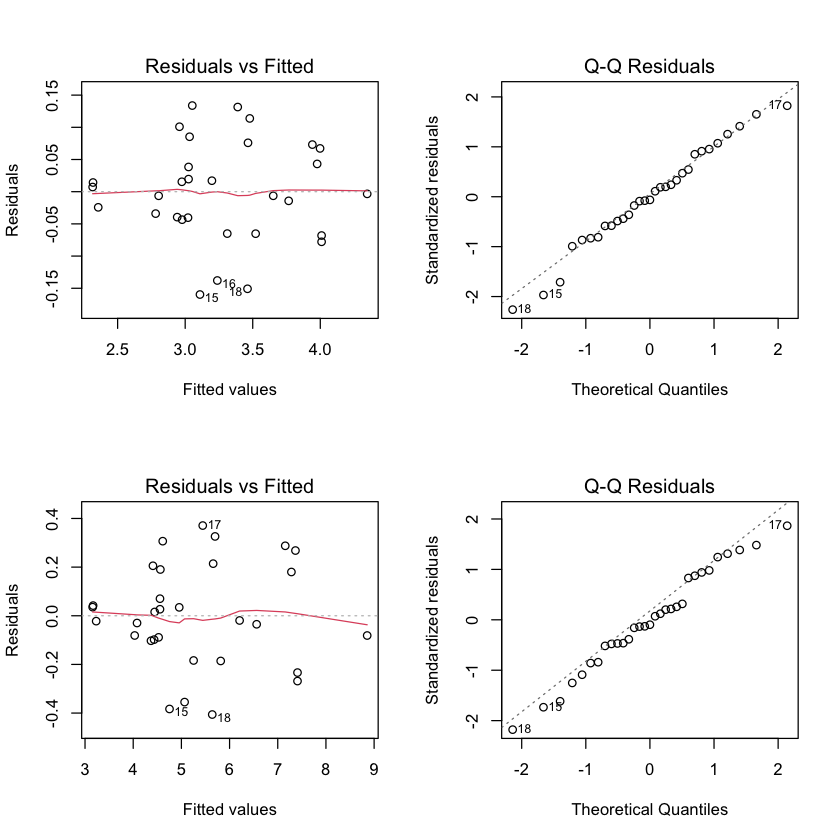

In [20]:
par(mfrow = c(2, 2))

plot(lmod_poly_log, which = 1)
plot(lmod_poly_log, which = 2)
plot(lmod_poly_sqrt, which = 1)
plot(lmod_poly_sqrt, which = 2)

shapiro.test(residuals(lmod_poly_log))
shapiro.test(residuals(lmod_poly_sqrt))

> *Interpretation:*  
>
> Our poly-log model has very well behaved residuals both in terms of homoscedasticity and normality. This is less of the case for our poly-sqrt transformation. 

<br>

## 6. 3D Visualizations

Below, we predict on a grid of `Girth` and `Height` values to visualize 3D surfaces for each model.

In [21]:
# Create 3D surface plots

plot_linear <- plot_ly() %>%
  add_surface(
    x = ~girth_range, y = ~height_range,
    z = ~matrix(pv_linear, nrow = length(girth_range)),
    colorscale = list(c(0,1), c("blue", "lightblue")),
    name = "Linear Model Surface"
  ) %>%
  add_markers(
    x = trees$Girth, y = trees$Height, z = trees$Volume,
    marker = list(color = "black", size = 3),
    name = "Actual Data"
  ) %>%
  layout(
    scene = list(
      xaxis = list(title = "Girth"),
      yaxis = list(title = "Height"),
      zaxis = list(title = "Volume")
    )
  )

plot_poly <- plot_ly() %>%
  add_surface(
    x = ~girth_range, y = ~height_range,
    z = ~matrix(pv_poly, nrow = length(girth_range)),
    colorscale = list(c(0,1), c("red", "orange")),
    name = "Polynomial Model Surface"
  ) %>%
  add_markers(
    x = trees$Girth, y = trees$Height, z = trees$Volume,
    marker = list(color = "black", size = 3),
    name = "Actual Data"
  ) %>%
  layout(
    scene = list(
      xaxis = list(title = "Girth"),
      yaxis = list(title = "Height"),
      zaxis = list(title = "Volume")
    )
  )

plot_log <- plot_ly() %>%
  add_surface(
    x = ~girth_range, y = ~height_range,
    z = ~matrix(pv_log, nrow = length(girth_range)),
    colorscale = list(c(0,1), c("green", "lightgreen")),
    name = "Log-Linear Model Surface"
  ) %>%
  add_markers(
    x = trees$Girth, y = trees$Height, z = trees$Volume,
    marker = list(color = "black", size = 3),
    name = "Actual Data"
  ) %>%
  layout(
    scene = list(
      xaxis = list(title = "Girth"),
      yaxis = list(title = "Height"),
      zaxis = list(title = "Volume")
    )
  )

plot_poly_log <- plot_ly() %>%
  add_surface(
    x = ~girth_range, y = ~height_range,
    z = ~matrix(pv_poly_log, nrow = length(girth_range)),
    colorscale = list(c(0,1), c("purple", "pink")),
    name = "Log-Polynomial Model Surface"
  ) %>%
  add_markers(
    x = trees$Girth, y = trees$Height, z = trees$Volume,
    marker = list(color = "black", size = 3),
    name = "Actual Data"
  ) %>%
  layout(
    scene = list(
      xaxis = list(title = "Girth"),
      yaxis = list(title = "Height"),
      zaxis = list(title = "Volume")
    )
  )

plot_sqrt <- plot_ly() %>%
  add_surface(
    x = ~girth_range, y = ~height_range,
    z = ~matrix(pv_sqrt, nrow = length(girth_range)),
    colorscale = list(c(0,1), c("yellow", "orange")),
    name = "Sqrt-Linear Model Surface"
  ) %>% 
  add_markers(
    x = trees$Girth, y = trees$Height, z = trees$Volume,
    marker = list(color = "black", size = 3),
    name = "Actual Data"
  ) %>%
  layout(
    scene = list(
      xaxis = list(title = "Girth"),
      yaxis = list(title = "Height"),
      zaxis = list(title = "Volume")
    )
  )

plot_poly_sqrt <- plot_ly() %>%
  add_surface(
    x = ~girth_range, y = ~height_range,
    z = ~matrix(pv_poly_sqrt, nrow = length(girth_range)),
    colorscale = list(c(0,1), c("brown", "orange")),
    name = "Sqrt-Polynomial Model Surface"
  ) %>%
  add_markers(
    x = trees$Girth, y = trees$Height, z = trees$Volume,
    marker = list(color = "black", size = 3),
    name = "Actual Data"
  ) %>%
  layout(
    scene = list(
      xaxis = list(title = "Girth"),
      yaxis = list(title = "Height"),
      zaxis = list(title = "Volume")
    )
  )

fig_linear_vs_poly <- subplot(
  plot_linear, plot_poly,
  nrows = 1,
  shareX = TRUE, 
  shareY = TRUE
) %>%
  layout(
    title = "Linear vs Polynomial Model Comparison with Actual Data",
    showlegend = TRUE
  )
 

fig_log_vs_poly_log <- subplot(
  plot_log, plot_poly_log,
  nrows = 1,
  shareX = TRUE, 
  shareY = TRUE
) %>%
  layout(
    title = "Log vs Polynomial Model Comparison with Log Response",
    showlegend = TRUE
  )

fig_sqrt_vs_poly_sqrt <- subplot(
  plot_sqrt, plot_poly_sqrt,
  nrows = 1,
  shareX = TRUE, 
  shareY = TRUE
) %>%
  layout(title = "Sqrt vs Polynomial Model Comparison with Sqrt Response", showlegend = TRUE)



library(htmlwidgets)

# Temporarily suppress all warnings
oldw <- getOption("warn")
options(warn = -1)

# Display the combined plot
# fig_linear_vs_poly
# fig_log_vs_poly_log
# fig_sqrt_vs_poly_sqrt

# Reset warning option to original state
options(warn = oldw)

![Plot 1](plots/plot1.png)
![Plot 2](plots/plot2.png)
![Plot 3](plots/plot3.png)

There is a clear visual difference between my polynomial and non polynomial graphs, with the volume of polynomial models less effected by increases in our height variable. I will now compare all of our models.

## 7. Model Comparison

We can compare each of these models using R², RMSE, and other relevant metrics to gauge fit and prediction accuracy:

In [22]:
# F critical value
alpha <- 0.01
model_summary <- summary(lmod_linear)
df1 <- model_summary$fstatistic[2]
df2 <- model_summary$fstatistic[3] 
f_critical <- qf(1 - alpha, df1, df2) 


# Prepare models
models <- list(
  "Linear" = lmod_linear,
  "Log" = lmod_log,
  "Poly" = lmod_poly,
  "Poly Log" = lmod_poly_log,
  "Sqrt" = lmod_sqrt,
  "Poly Sqrt" = lmod_poly_sqrt
)


performance_df <- compare_performance(models)
performance_df <- as.data.frame(performance_df)
performance_df <- performance_df[, c("Name","R2", "RMSE", "Sigma")]
performance_df


f_critical

Name,R2,RMSE,Sigma
<chr>,<dbl>,<dbl>,<dbl>
Linear,0.9479500,3.68922301,3.88183204
Log,0.9684500,0.09195711,0.09675806
Poly,0.9782590,2.38432126,2.65506779
Poly Log,0.9784175,0.07605642,0.08469285
Sqrt,0.9675477,0.25163354,0.26477097
Poly Sqrt,0.9779121,0.20759801,0.23117136


[1] 5.452937

> *Interpretation:*  
> - **R²** measures the proportion of variability explained.  
> - **RMSE** (Root Mean Squared Error) quantifies average predictive error.  
> - Typically, higher R² and lower RMSE indicate a better predictive model.

## 8. Final Model Evaluation

Across all our transformed models, we observe a consistent improvement in explained variance, with an increase of approximately 0.03 compared to the original model. The poly-log model performs the best, achieving a root mean squared error (RMSE) of 0.08. Additionally, transformations such as applying a square root to both the response and predictor or a logarithmic transformation to just the response result in much better residual structure.

If our priority is prediction, the poly-log model would be the best choice. It offers the highest  $R^2$ , a very low RMSE, and well-behaved residuals. However, this comes at the cost of interpretability due to its complexity.

On the other hand, if the goal is to better understand the relationship between volume, girth, and height, the linear model is a reasonable choice. Despite minor heteroskedasticity, the errors are normally distributed, and the linear model provides a clear and interpretable relationship between variables.